#### A time series forecasting of covid-19 cases 
- Create a Sequence and specify the sequence length of sequence for sub-sequencesfor each time step
- scale the data with MinMaxScaler
- Define the LSTM design pattern
- Train the model
- Determine the number of days to predict ahead

#### Import packages

In [36]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'


sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#### Data Exploration

In [37]:
# confirmed cases
confirmed_cases = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_cases = pd.DataFrame(confirmed_cases)
confirmed_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,237,273,281,299,349,367,423,444,484,521
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,259,277,304,333,361,377,383,400,409,416
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,847,986,1171,1251,1320,1423,1468,1572,1666,1761
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,390,428,439,466,501,525,545,564,583,601
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,8,8,8,10,14,16,17,19,19,19


In [38]:
# We don't need the country, Province, lat and Long to make forecasting so we drop it
confirmed_cases = confirmed_cases.iloc[:, 4:]
confirmed_cases.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20
0,0,0,0,0,0,0,0,0,0,0,...,237,273,281,299,349,367,423,444,484,521
1,0,0,0,0,0,0,0,0,0,0,...,259,277,304,333,361,377,383,400,409,416
2,0,0,0,0,0,0,0,0,0,0,...,847,986,1171,1251,1320,1423,1468,1572,1666,1761
3,0,0,0,0,0,0,0,0,0,0,...,390,428,439,466,501,525,545,564,583,601
4,0,0,0,0,0,0,0,0,0,0,...,8,8,8,10,14,16,17,19,19,19


In [39]:
# check for missing values
confirmed_cases.isnull().sum().sum()

0

In [40]:
# Lets sum each column so we get the total number of each cases daily
confirmed_cases_daily = confirmed_cases.sum(axis=0)

In [41]:
# convert the date to readable datetime
confirmed_cases_daily.index = pd.to_datetime(confirmed_cases_daily.index)
confirmed_cases_daily.head()

2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Cummulative daily cases')

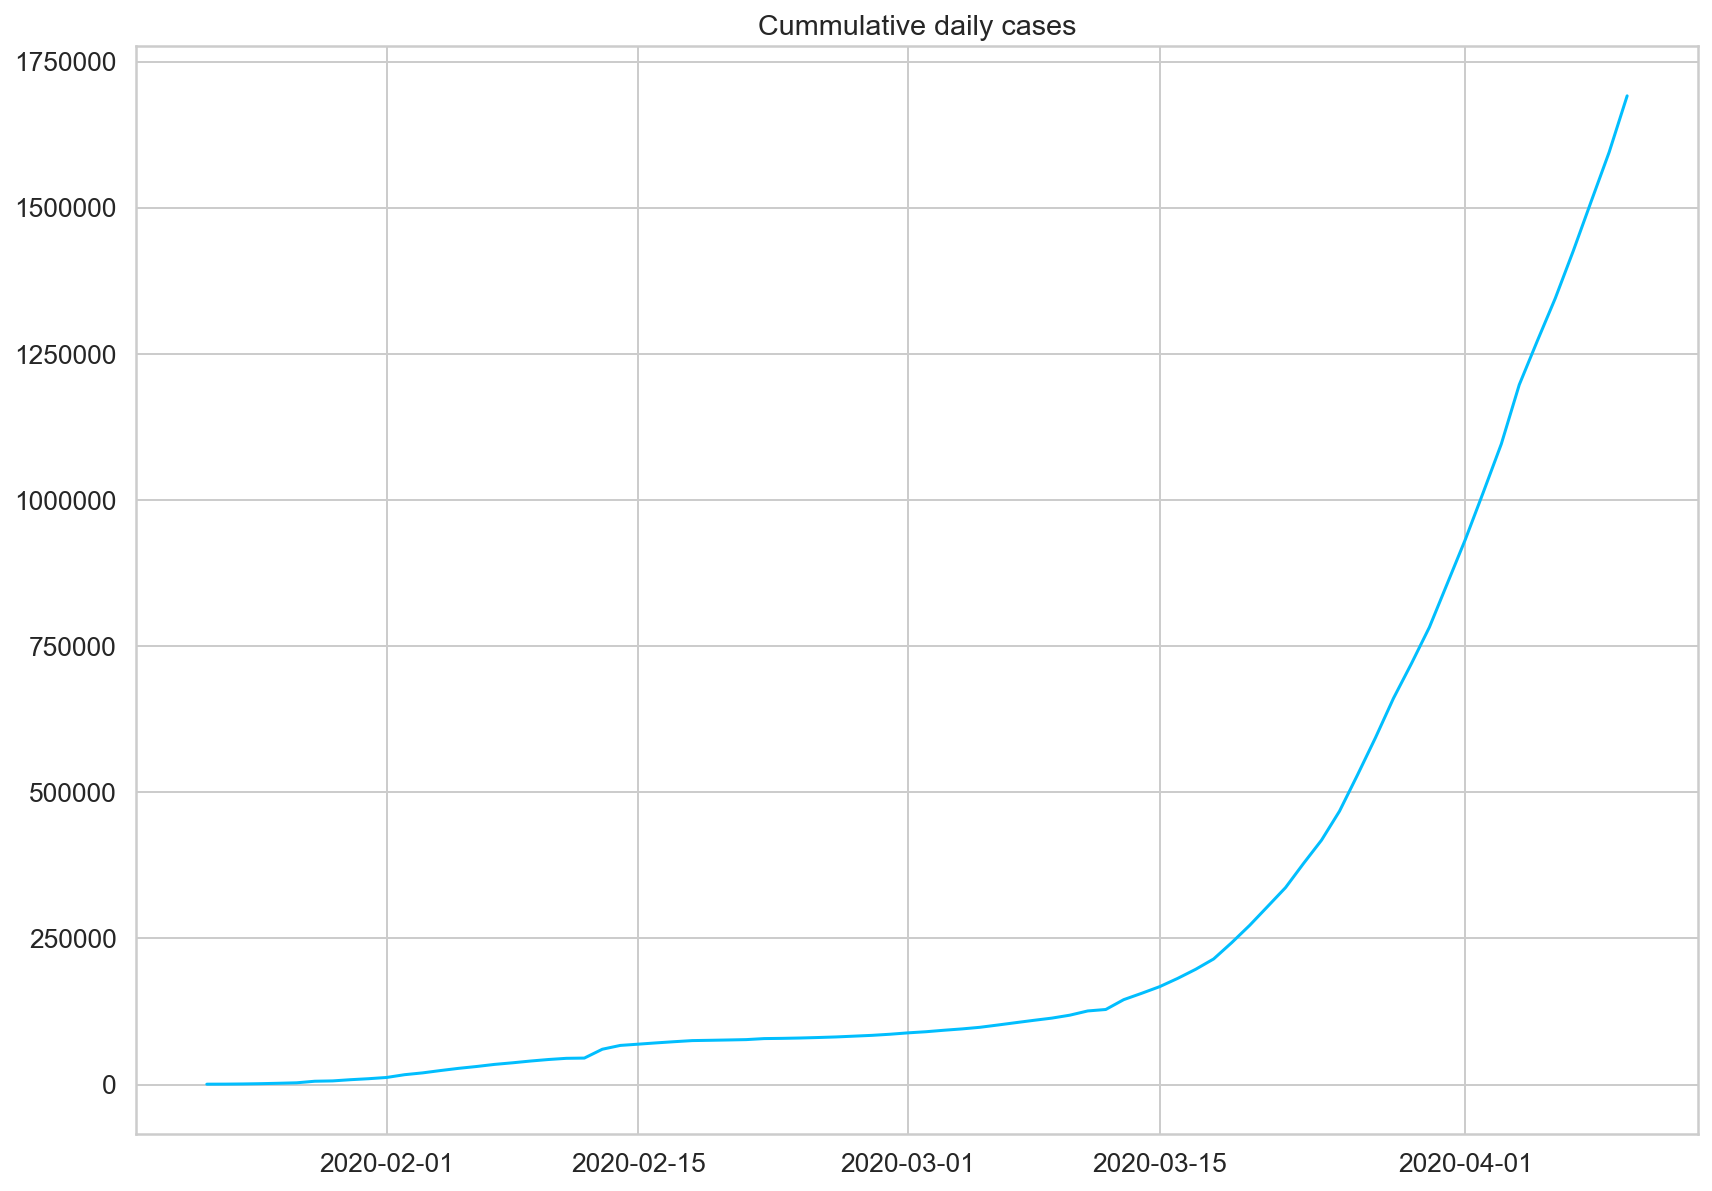

In [42]:
plt.plot(confirmed_cases_daily)
plt.title('Cummulative daily cases')

In [43]:
# we need to know the number of new cases daily without adding the first day cases
# we do the difference between each day and preserver the first day
confirmed_cases_daily = confirmed_cases_daily.diff().fillna(confirmed_cases_daily[0]).astype(np.int64)
confirmed_cases_daily.head()

2020-01-22    555
2020-01-23     99
2020-01-24    287
2020-01-25    493
2020-01-26    684
dtype: int64

Text(0.5, 1.0, 'Daily cases')

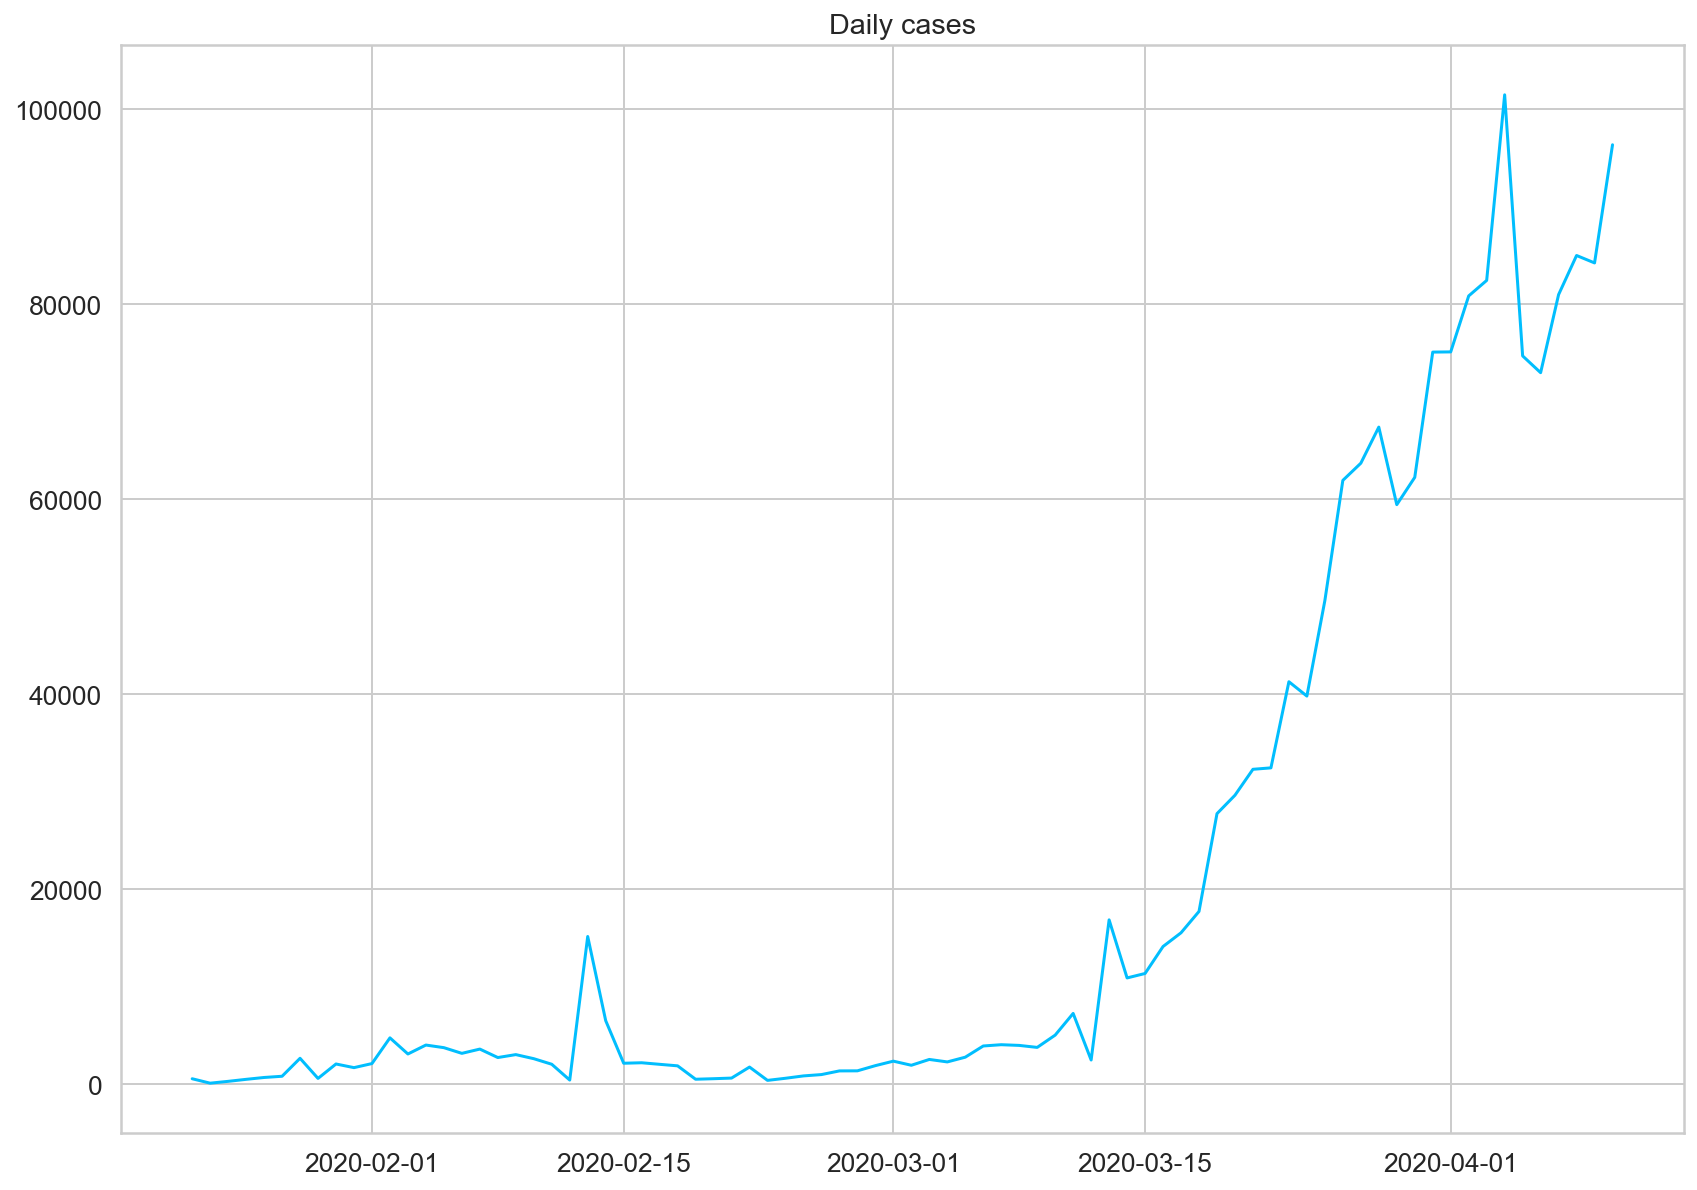

In [44]:
plt.plot(confirmed_cases_daily)
plt.title("Daily cases")

In [45]:
# check all the total number of dataset i.e all the days
confirmed_cases_daily.shape

(80,)

#### Data Preprocessing

In [46]:
# split the data
test_size = 15
train_data = confirmed_cases_daily[:-test_size]
test_data = confirmed_cases_daily[-test_size:]

train_data.shape

(65,)

In [47]:
# Normalizing the data to increase the performance and ensure the data range from 0-1
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [48]:
def create_sequence(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [49]:
seq_length = 5
X_train, y_train = create_sequence(train_data, seq_length)
X_test, y_test = create_sequence(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [50]:
X_train.shape

torch.Size([59, 5, 1])

In [51]:
y_train.shape

torch.Size([59, 1])

In [52]:
X_train[:2]

tensor([[[0.0074],
         [0.0000],
         [0.0030],
         [0.0064],
         [0.0095]],

        [[0.0000],
         [0.0030],
         [0.0064],
         [0.0095],
         [0.0115]]])

In [53]:
y_train[:2]

tensor([[0.0115],
        [0.0413]])

## Building a two layers model
- 1 LSTM Layer
- 1 LInear (fully connected Layer)
- view function is used for reshaping data

In [54]:
# Build the model
"""
Architecture Block
Sequences -> LSTM Layer -> Linear Layer -> Output prediction
"""

class CovidPrediction(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CovidPrediction, self).__init__()
        
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.5
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
        
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        y_pred = self.linear(
        lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1])
        return y_pred

In [55]:
# Training
def model_train(
    model,
    train_data,
    train_labels,
    test_data=None,
    test_labels=None):

    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 60
    
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        
        y_pred = model(X_train)
        
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss:{loss.item()}')
            
        train_hist[t] = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model.eval(), train_hist, test_hist

In [56]:
model = CovidPrediction(
    n_features = 1,
    n_hidden = 512,
    seq_len = seq_length,
    n_layers=2)

model, train_hist, test_hist = model_train(
    model,
    X_train,
    y_train,
    X_test,
    y_test)

Epoch 0 train loss: 2.7190768718719482 test loss: 15.65473747253418
Epoch 10 train loss: 1.6665387153625488 test loss: 7.014430046081543
Epoch 20 train loss: 1.0169212818145752 test loss: 7.198132038116455
Epoch 30 train loss: 0.7943506836891174 test loss: 183.52801513671875
Epoch 40 train loss: 0.7266407012939453 test loss: 310.8301086425781
Epoch 50 train loss: 0.6089906096458435 test loss: 232.6636199951172


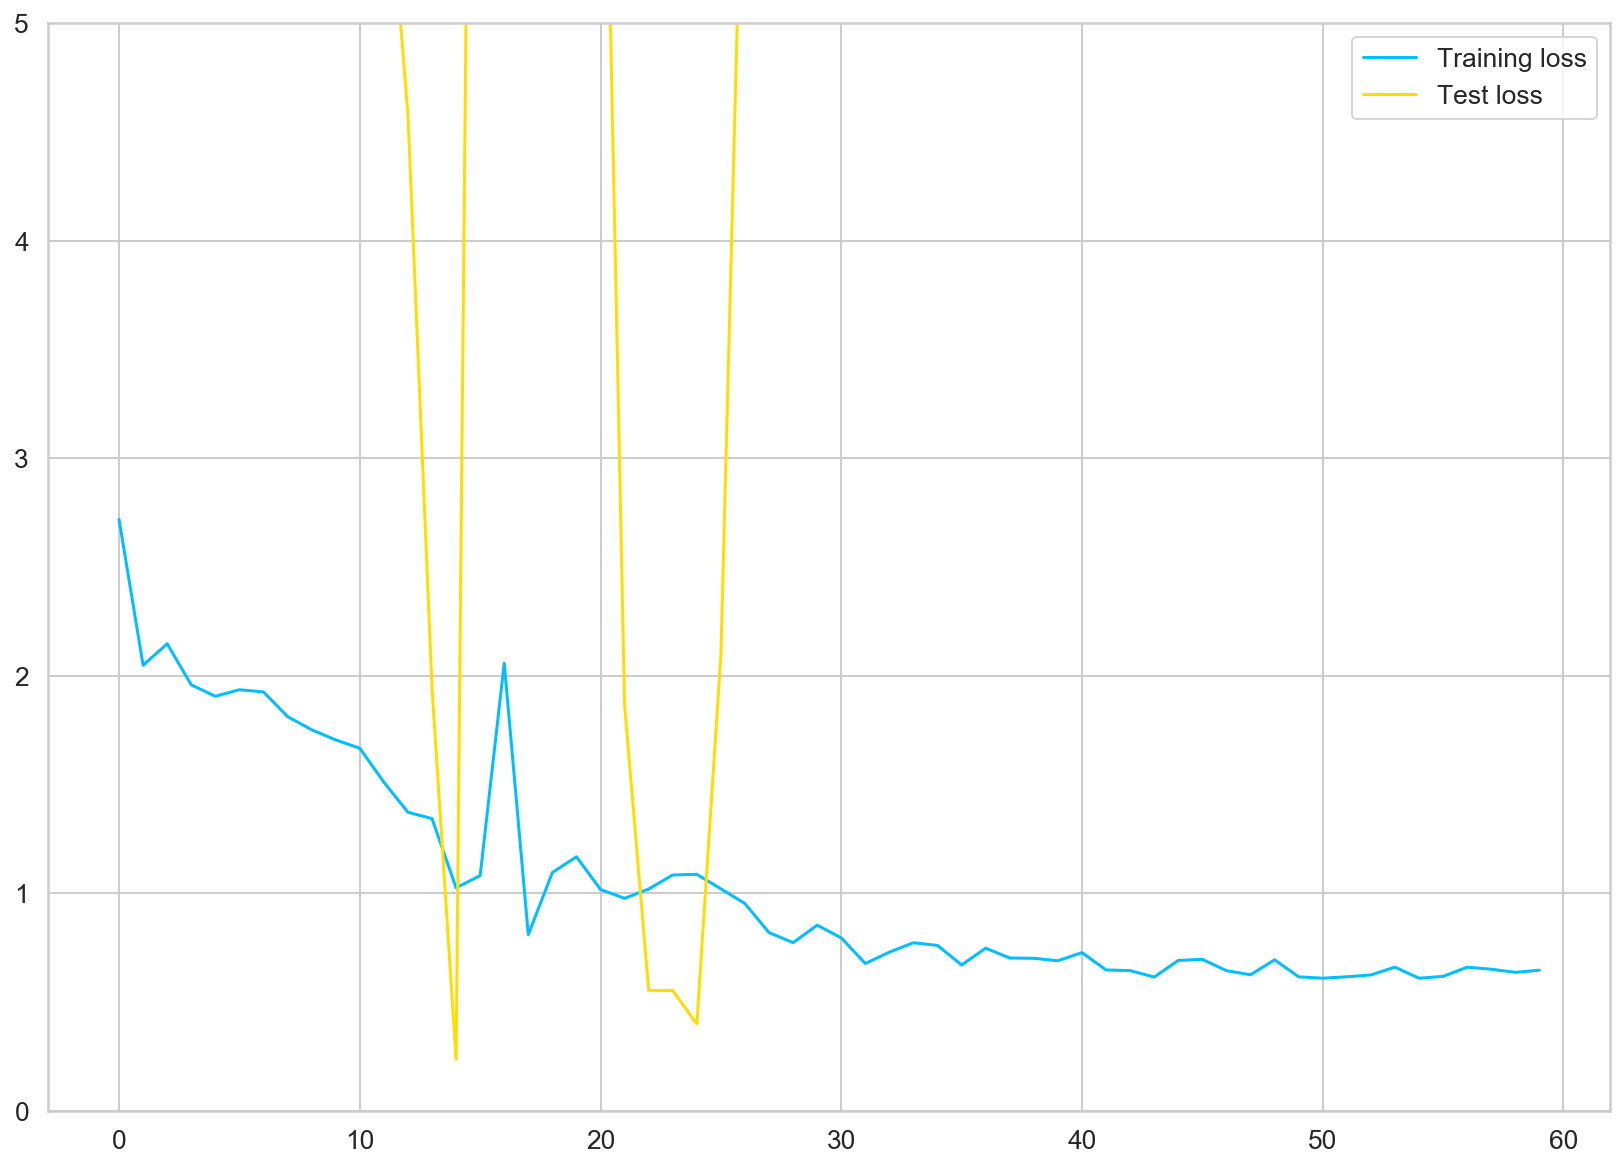

In [57]:
plt.plot(train_hist, label='Training loss')
plt.plot(test_hist, label='Test loss')
plt.ylim((0, 5))
plt.legend();

In [58]:
# Prdicting daily cases 
# we can only predict a single day

with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred)
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()